Abstract: The objective of the work behind this paper was to explore and adopt the most accurate data-driven method for calculation of thermal inertia parameters, namely dead time and time constant at the level of apartments in a local DHS. Three methods were used, namely cross-correlation analysis, the event detection and analysis by using First-Order Plus Dead Time (FOPDT) model, and analysis of SHAP feature importances for the Machine Learning (ML) regression model. The paper presents the results of the test and insights gained, on the dataset using 3-minute resolution data, including control parameters and measured room temperature during heating season 2024/25, collected in a local DHS. While most computationally efficient, cross-correlation analysis was found to detect longer dead times than event detection method. These differences are attributed mainly to the differences in scope of the data being analysed, where the latter method focuses on selected chunks of data corresponding to clearly highlighted events. ML/SHAP method produced shorter time constants than event detection method, with consistent ordering across apartments to that method. In conclusion, the event detection/FOPDT method was adopted as it produces a physically grounded, event-specific estimate that is more relevant for predictive control tuning and dynamic system identification.

# Introduction

Thermal inertia is the ability of a building to resist temperature changes due to thermal mass and system dynamics. It is one of the important factors in optimizing the operation of District Heating Systems (DHS). Accurate estimation of thermal inertia enables more responsive and predictive control strategies; it improves energy efficiency and resident comfort but also contributes to the transparency of the public heating service, by considering the delayed effect of heat delivery on indoor climate.

The work behind this paper explores different methods to quantify the thermal inertia of buildings connected to a DHS by analyzing high-resolution time-series data originating from DHS' SCADA and indoor sensors, collected over a full heating season 2024/25, focusing on the dynamic response of indoor temperature to changes in heat supply and external weather conditions. The time series data includes 3-minute resolution measurements of supply and return water temperatures in both primary and secondary circuits, ambient outdoor temperature and other weather features, delivered heat energy, and room-level sensor readings (temperature, relative humidity, and CO2 levels).

Thermal inertia for the specific DHS substation data is inferred by using three different techniques. Statistical methods, such as cross-correlation and lagged regression are used to find the time delay with highest correlation between secondary supply temperature or transmitted energy with room temperature. Event detection method detects operating cycles of the DHS, use simple gradient assessment approach to measure dead time and then fit First-Order-Plus-Dead-Time (FOPDT) model to calculate time constant. Machine Learning (ML) surrogate models are also used as a proposed method. ML models are trained by using gradient boosting algorithms to predict room temperature based on lagged inputs. Then cumulative normalized feature importance analysis, with adopted thresholds indicating dead times and time constants, was implemented by using SHAP eXplainable AI (XAI) method.

The research presented in this paper demonstrates how real-time availability of operational data from substations and smart indoor sensors can be used to infer thermal inertia, rather than using physics-based approaches. White-box methods require quite extensive (often not available) input data, and they often assume idealized conditions. Normally, those methods are more relevant for design optimization or compliance modeling, data-driven approaches are more fit for operational analysis, control optimization and fault detection.

The literature review uncovered a growing variety of data-driven methods to estimate or exploit thermal inertia in district-heated residential buildings. Methodologies used range from grey-box system identification to purely statistical analyses of demand lag, and modern Machine Learning techniques that infer inertia from time-series data. A common finding is that residential buildings have significant and quantifiable thermal inertia that can be identified through data. Researchers consistently report that considering this inertia improves heating predictions and control. Namely, dynamic models with memory outperform static, physical models, and control schemes that consider inertia continuously outperform reactive control (Ma et al, 2022). There is also consensus that thermal inertia enables load flexibility. Namely, buildings can be pre-heated or temporarily under-heated to shift loads without immediate comfort loss (Aoun et al, 2019). However, the literature also shows that buildings differ widely in inertia, and simple building metadata are not always good predictors of inertia (Pothof et al, 2023). This underscores the value of data-driven estimation for each specific building or cluster. The special importance of data-driven approach is that it can provide estimations at the micro-level, at the level of apartment, normally very difficult and unfeasible with using physics models.

Several recent studies use grey-box modeling to quantify thermal inertia from data. In these methods, building heat loss and heat capacity parameters are identified by fitting model outputs to measured data. For example, Pothof et al. (2023) fit a second-order RC model (2R2C) to hourly data from 220 Dutch homes, by using data of flow rates and supply/return water temperatures at boilers (or substations), indoor room thermostat readings, and local weather (outdoor temperature, solar irradiation). The fitted model produced estimates of the building's heat loss coefficient and effective thermal capacitances (thermal mass). A key finding was that many existing homes have significant thermal inertia allowing lower heating supply temperatures: the identified models showed that 60% of the dwellings could maintain comfort even if supply temperature is below 55 °C in design-cold conditions. Grey-box modeling has also been extended to capture nonlinearity in heating systems. For example, Monghasemi et al. (2022) developed a non-linear grey-box model for a multi-unit residential building on a Swedish district heating network.

Rather than detailed RC models, some works directly analyze heat demand data to extract the time-lag associated with thermal inertia. For example, to capture thermal inertia, Borgato et al. (2024) evaluated the correlation between a building's heat demand and the moving average of outdoor temperature over preceding hours. A more direct way to estimate inertia is through controlled step-response experiments. In the context of HVAC demand response, researchers have performed thermostat setpoint step changes to measure how slowly a building's temperature falls or rises, which directly produces a thermal time constant. For instance, an experimental study (Huang et al., 2021) on a commercial building documented that after cutting off heating, indoor temperature dropped only gradually due to the building's high thermal mass. They developed a method to quantify the effective thermal capacitance from such operational data.

Another stream of research employs ML models to capture building thermal behavior from data, implicitly learning the effects of thermal inertia. These black-box approaches do not produce explicit RC parameters, but they quantify inertia through the model's temporal memory and response characteristics. For example, Ma et al. (2022) used a Long Short-Term Memory (LSTM) neural network to model the indoor temperature response in buildings on a district heating system. In their data-driven control framework, sensors recorded indoor air temperature, DH water supply temperature, flow rate, and weather conditions for three public buildings. An LSTM was trained to predict next-hour indoor temperature from these inputs, effectively learning the building's thermal dynamics. The LSTM model captured the delay in room heating due to the building's thermal inertia, which the authors note was about a 3-hour settling time after a setpoint change. It was proven (Vivian et al, 2024) that, with sufficient training data, ML models can predict building thermal responses comparably or even better than physics-based models, and they inherently capture inertia effects through temporal patterns.

# Methodology

Dead time is the time delay between a change in the heating system's input and the first measurable effect on the indoor (apartment) temperature. Dead time comes from heat transport delay in pipes, the thermal mass of heat exchanger water, and the lag in room air mixing before sensors pick up change. Control engineers need θ to tune heating control loops. Inertia calculations use it to separate "pure delay" from "gradual response" (τ). Forecasting models improve when θ is explicitly included - it prevents overestimating τ.

In the context of a district heating system, the time constant (𝜏) describes how quickly the indoor temperature responds once the dead time has passed. In a first-order dynamic system, the time constant 𝜏 is the time required for the output (indoor temperature) to reach approximately 63.2% of its total change after a step change in the input (heat power), excluding the dead time.

In DHS context, small 𝜏 implies that the room warms up quickly after heat input begins, due to a low thermal mass or high heat transfer rate. Large 𝜏 means that the room warms up slowly (high thermal mass, low radiator capacity, or reduced flow rate). 𝜏 reflects a combination of heat transfer capacity from radiators to room air; thermal capacity of air, walls, and furnishings and; heat loss coefficient to the outside environment.

Time constant 𝜏 is a key inertia parameter. In combination with θ, it characterizes the dynamic heating behaviour in the simplest model.

## Cross-correlation analysis

To decompose the thermal response dynamics of the district heating system (DHS), we apply a stage-wise cross-correlation that quantifies time delays between hydraulic/thermal variables measured at distinct locations. This separates delays due to: 

1. heat exchanger and substation control valve (Stage 1), the lag between primary supply and secondary supply: X(t)=T<sub>sup_prim</sub>(t), Y(t)=T<sub>sup_sec</sub>(t)
2. secondary hydraulic circuit (Stage 2), lag between secondary supply and secondary return: X(t)=T<sub>sup_sec</sub>(t), Y(t)=T<sub>ret_sec</sub>(t)
3. building-side thermal inertia (Stage 3), lag between secondary supply and indoor temperature rate: X(t)=T<sub>sup_sec</sub>(t), Y(t)=T<sub>room</sub>(t)

For each stage, the non-negative-lag Pearson cross-correlation is computed over lags k∈{0,1,..,k<sub>max</sub>}
$$
\rho_{XY}(k) \;=\; 
\frac{\sum_{t} X(t)\,Y(t+k)}{\sqrt{\sum_{t} X(t)^2} \;\sqrt{\sum_{t} Y(t+k)^2}},
\qquad k \ge 0,
$$
with a search horizon k<sub>max</sub> corresponding to 360 min. The dead time θ for a given stage is defined as the lag (in minutes) that maximizes the correlation:
$$
\theta \;=\; \underset{k \ge 0}{\arg\max}\;\rho_{XY}(k)\;\cdot\;\Delta t_{\min},
\qquad \Delta t_{\min}= \Delta t \;[\mathrm{min}],
$$
and the corresponding peak correlation $\rho_{\max} = \max_{k \ge 0}\rho_{XY}(k)$ is recorded as a strength indicator.

## Event detection and First-Order Plus Dead Time model

The thermal response of each monitored room was quantified using a First-Order Plus Dead Time (FOPDT) model, in which the indoor air temperature response, T(t), to a step change in heating system input is described by

$$
T(t) = T_{\infty} - \left(T_{\infty} - T_0\right) e^{-t / \tau}, \quad t \ge \theta_{\mathrm{total}},
$$

where T<sub>∞</sub> is the steady-state temperature after the heating event, T<sub>0</sub> is the temperature at the onset of the response, τ is the first-order time constant, and θ<sub>total</sub> is the total dead time from the heating valve actuation to the detectable indoor response.

The input signal U(t) was defined as the secondary supply temperature t<sub>sup_sec</sub>. The code first identified step-up events in U(t) by calculating its discrete difference ΔU and selecting indices where ΔU≥ρ<sub>min</sub>, with ρ<sub>min</sub>=0.5C. A persistence criterion of n<sub>pers</sub>=3 samples ensured that only sustained steps were considered. Events were further filtered to require at least 0.7ρ<sub>min</sub> persistence in the mean level after the step.

To account for transport delay in the secondary loop (Stage B), a fixed offset θ<sub>sec</sub>=15 min was added to each detected step time t<sub>s</sub> before analysing the room response. For each candidate event, the time derivative of the room temperature, $\frac{\mathrm{d}T}{\mathrm{d}t}$, was computed, and the onset of response t<sub>onset</sub> was defined as the first time point where $\frac{\mathrm{d}T}{\mathrm{d}t} > 0.02 \ \mathrm{K/h}$. In simpler words, we check the rate of change of the room temperature and mark the moment when it starts rising faster than 0.02 K/h as the true start of the thermal effect. The total dead time was then

$$
\theta_{\mathrm{total}} = t_{\mathrm{onset}} - t_s.
$$


In our approach, K is the static gain of the room's thermal response to a step change in supply temperature. In the event–based calculation we calculate is as the simple ratio:

$$
K = \frac{\Delta y}{\Delta u}
$$

where Δy is change in room temperature between pre– and post–step steady states and Δu is change in supply temperature over the same interval.  

The portion of the temperature trajectory following t<sub>onset</sub> was then fitted to the exponential model using nonlinear least squares to estimate τ. The fit is constrained to realistic ranges so we don't get nonsensical results from noisy events. Hence, bounds were imposed on the parameters to ensure physical plausibility, constraining τ to 1 min ≤ τ ≤ 2000 min  and temperatures within the observed range for each event.

Events with insufficient data length (< 6 samples after t<sub>onset</sub>) or minimal net temperature change (< 0.2C) were excluded to avoid unreliable fits. For each room, the median values of θ<sub>total</sub> and τ across all valid events were reported, along with the total number of fitted events.

This approach explicitly separates the transport delay from the emitter–air thermal coupling dynamics, allowing for a direct estimation of the building’s thermal inertia via τ while capturing the total lag between control actuation and perceptible thermal effect through θ<sub>total</sub>.


## Machine Learning surrogate model

In this approach to extract tau and teta, we use ML surrogate model. The approach is based on the extraction of lag-importance profiles from a machine learning regression model trained to predict the indoor air temperature using recent histories of supply temperature, ambient temperature, and autoregressive indoor temperature values. A gradient-boosted regression tree model is employed in a one-step-ahead prediction framework. For each apartment, the model is fitted using lagged values of the supply temperature signal u(t), the ambient temperature signal x(t), and the indoor temperature signal y(t), with the maximum number of lags corresponding to a fixed physical time horizon.

The relative predictive contribution of each supply temperature lag is then quantified using SHAP (SHapley Additive exPlanations) values. SHAP provides an additive decomposition of the model's output into contributions from individual features, enabling the aggregation of absolute contributions for all instances to obtain a mean absolute SHAP value per lag. The resulting lag-importance profile I(k), where k is the lag index, captures the temporal distribution of predictive influence from the supply temperature history.

In this study, the parameters θ, τ were derived from the cumulative normalized importance of lagged supply temperature features, as estimated via SHAP analysis. First, the mean absolute SHAP value was computed for each supply temperature lag, quantifying the marginal contribution of that lagged feature to the prediction of indoor air temperature. These values were then normalized by the sum of importances across all considered lags, producing a dimensionless distribution whose elements sum to unity. This normalization enables comparability across apartments and datasets by removing the influence of the absolute scale of model outputs. Subsequently, the cumulative sum of the normalized importances was calculated as a function of lag, representing the proportion of the total predictive influence attributable to lags up to a given time. The dead time θ was defined as the earliest lag at which the cumulative normalized importance exceeded 2% of the total, while the time constant proxy τ was defined as the lag at which 63.2% of the total importance was reached. This approach allows for a robust, data-driven estimation of thermal response parameters that is independent of explicit physical step-change experiments.

From this profile, θ and τ are inferred as follows:

Dead time (θ) is defined as the earliest lag time at which the cumulative normalized importance exceeds a small threshold ρ<sub>θ</sub> (e.g., 5% of the total). This represents the minimum delay after a change in supply temperature before a measurable effect is typically observed in the indoor temperature response.

Time constant (τ) is defined as the lag time at which the cumulative normalized importance reaches ρ<sub>τ</sub> (e.g., 63.2% of the total). This is analogous to the classical first-order system definition, representing the time required for the dominant part of the response to be realized.

Both parameters are expressed in minutes by multiplying the corresponding lag index by the sampling interval. This method does not require fitting an explicit parametric model to the temperature response, but instead infers the dominant temporal dynamics directly from the predictive structure captured by the ML model. The use of SHAP ensures model-agnostic interpretability while retaining the non-linear, multivariate dependencies between the predictors and the target variable.

# Implementation and discussion of results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore


from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

import requests
import zipfile
import io
import warnings

import os
import shutil

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


season_start='2024-11-17 06:00:00'
season_end='2025-04-01 00:00:00'

## Data opening and preprocessing

SCADA data is collected from 5 buildings in 4 blocks (DHS substations) and total of 20 apartments. For convenience, the paper will discuss only control data from one substation (block L4) and one apartment. Data is collected from SCADA system of the local DHS and Thermionyx devices that were installed in the apartments before the beginning of the heating season. 

Before the analysis, data was pre-processed. The features that are considered non-relevant for this problem were removed. Missing data, normally caused by the sensor or communication infrastructure faults were replaced with interpolated values. Small values of heat load (again, sensor faults) were replaced with 0. The outliers were detected (zscore>4) and replaced with linearly interpolated values. The columns corresponding to the apartment data were renamed for the anonymization purpose. 

Finally, low-pass filtering of room temperatures was implemented, by using Savitzky–Golay filter. Room temperature changes in DHS are slow (hours), so anything oscillating faster than ~10–15 min is almost certainly noise. Removing this high-frequency noise improves derivative estimates and curve fitting without distorting the true dynamics. Small measurement noise in the apartment temperature can cause large fluctuations and make unstable future computations.

In [3]:
# Download the zip file from GitHub
url_scada = "https://github.com/xai4heat/xai4heat/raw/main/datasets/scada_data_2024-25.zip"
url_thermionyx = "https://github.com/xai4heat/xai4heat/raw/main/datasets/thermionyx_data_2024-25_1min.zip"

response_scada = requests.get(url_scada)
response_thermionyx = requests.get(url_thermionyx)

with zipfile.ZipFile(io.BytesIO(response_scada.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith('.csv')]
    with z.open(csv_files[0]) as f:
        dfs = pd.read_csv(f)

with zipfile.ZipFile(io.BytesIO(response_thermionyx.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith('.csv')]
    with z.open(csv_files[0]) as f:
        dft = pd.read_csv(f)


# Processing Thermionyx data

dft['datetime'] = pd.to_datetime(dft['datetime'])
dft.set_index('datetime', inplace=True)
dft.sort_index(inplace=True)

dft['sensor_co2'] = dft['name'].str.endswith('_CO2')
name_parts = dft['name'].str.replace('_CO2$', '', regex=True).str.split('_', expand=True)
dft['block_name'] = name_parts[0]
dft['building_number'] = name_parts[1]
dft['apartment_number'] = name_parts[2]

dft.drop(columns=['probe_id', 'name'], inplace=True)


# Create a hierarchical structure block_name -> building_number -> apartment_number.

thermionyx_hierarchy = {}
for _, row in dft.reset_index().iterrows():
    block = row['block_name']
    building = row['building_number']
    apartment = row['apartment_number']
    thermionyx_hierarchy.setdefault(block, {}).setdefault(building, set()).add(apartment)

# Convert sets to sorted lists for easier use
for block in thermionyx_hierarchy:
    for building in thermionyx_hierarchy[block]:
        thermionyx_hierarchy[block][building] = sorted(thermionyx_hierarchy[block][building])



# Get all Thermionycs data in location_groups_t

location_groups_t = {}

merged_all = None

for block_name, buildings in thermionyx_hierarchy.items():
    print(f"Block: {block_name}")
    for building_number, apartments in buildings.items():
        print(f"  Building: {building_number}")
        print(f"    Apartments: {', '.join(apartments)}")

        for apartment_number in apartments:
            ff1=dft[(dft['block_name'] == block_name) & (dft['building_number'] == building_number) & (dft['apartment_number'] == apartment_number) & (dft['sensor_co2'] == False)][['temperature', 'relative_humidity']].resample('3min').first()
            ff2=dft[(dft['block_name'] == block_name) & (dft['building_number'] == building_number) & (dft['apartment_number'] == apartment_number) & (dft['sensor_co2'] == True)][['co2']].resample('3min').first()
            ff1 = ff1.rename(columns=lambda col: f"{col}_{building_number}_{apartment_number}")
            ff2 = ff2.rename(columns=lambda col: f"{col}_{building_number}_{apartment_number}")
            merged = pd.merge(ff1, ff2, left_index=True, right_index=True, how='outer')

            if merged_all is None:
                merged_all = merged
            else:
                merged_all = pd.merge(merged_all, merged, left_index=True, right_index=True, how='outer')

    merged_all.dropna(axis=1, how='all', inplace=True)
    location_groups_t['TPS Lamela '+block_name] = merged_all
    merged_all = None



location_groups = {loc: dfs[dfs['location'] == loc] for loc in dfs['location'].unique()}
columns_to_update = ['t_amb', 't_ref', 't_sup_prim', 't_ret_prim', 't_sup_sec', 't_ret_sec']

for df in location_groups.values():
    k = [key for key, value in location_groups.items() if value is df][0]

    df.drop(columns='location', inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    #Is there a zero energy data - calorimeter failures?
    zero_count = (df['e'] == 0).sum()
    if(zero_count>0):
        print('calorimeter failures in ', k, ', number of zero values: ', zero_count, ' replacing with interpolated values..')
        df['e'] = df['e'].replace(0, np.nan)
        for column in columns_to_update:
            df.loc[df['e'].isna(), column] = np.nan
        df.interpolate(method='linear', inplace=True)
        df.set_index('datetime', inplace=True)


    df = df[~df.index.duplicated(keep='first')]
    df = df.resample('3min').first().dropna(how='all')

    for col in df.columns:
        df[col] = df[col].astype(float)
    df.sort_index(inplace=True)

    df['qizm']=(df['e']-df['e'].shift(1))*1000

    date_range_season = (df.index >= pd.to_datetime(season_start)) & (df.index < pd.to_datetime(season_end))
    df = df[date_range_season].copy()

    #Small values of heat load replaced with 0
    df['qizm'] = df['qizm'].apply(lambda x: 0 if x <= 31 else x)

    #Replacing outliers with linearly interpolated values
    zs = zscore(df['qizm'])
    df.loc[np.abs(zs) > 4, 'qizm'] = np.nan
    df['qizm'] = df['qizm'].interpolate(method='linear')

    #Dropping columns
    df.drop(columns=['e', 'pe'], inplace=True)


    #Merging with Thermionyx data
    if k in location_groups_t and location_groups_t[k] is not None:
        df = pd.merge(df, location_groups_t[k], left_index=True, right_index=True, how='left')

    df.dropna(axis=1, how='all', inplace=True)

    location_groups[k] = df


dftc=location_groups['TPS Lamela L4'].copy()


dftc.interpolate(method='linear', inplace=True)


dftc.rename(columns={'temperature_37_2': 'rtemp_1',
                     'temperature_37_4': 'rtemp_2',
                     'temperature_37_9': 'rtemp_3',
                     'temperature_37_12': 'rtemp_4',
                     'temperature_37_15': 'rtemp_5',
                     'relative_humidity_37_2': 'rhumid_1',
                     'relative_humidity_37_4': 'rhumid_2',
                     'relative_humidity_37_9': 'rhumid_3',
                     'relative_humidity_37_12': 'rhumid_4',
                     'relative_humidity_37_15': 'rhumid_5',
                     'co2_37_12': 'rco2_4',
                     }, inplace=True)


# Incremental energy is in kWh. Qin is the instantaneous heat power delivered to the secondary side of the district heating substation — the actual thermal input that goes into heating the apartments.
dftc["qin"] = dftc["qizm"] / (3/60)


# Low-pass filtering is implemented, with Savitzky–Golay filter.

from scipy.signal import savgol_filter
dftc["rtemp_1"] = savgol_filter(dftc["rtemp_1"], window_length=7, polyorder=2)
dftc["rtemp_2"] = savgol_filter(dftc["rtemp_2"], window_length=7, polyorder=2)
dftc["rtemp_3"] = savgol_filter(dftc["rtemp_3"], window_length=7, polyorder=2)
dftc["rtemp_4"] = savgol_filter(dftc["rtemp_4"], window_length=7, polyorder=2)


dftc.info()

Block: L4
  Building: 37
    Apartments: 12, 15, 2, 4, 9
Block: L17
  Building: 35
    Apartments: 11, 16, 2, 5, 7
Block: L8
  Building: 53
    Apartments: 12, 13, 2, 20, 8
Block: L12
  Building: 21
    Apartments: 18, 2
  Building: 19
    Apartments: 1, 18, 2
calorimeter failures in  TPS Lamela L8 , number of zero values:  52  replacing with interpolated values..
calorimeter failures in  TPS Lamela L4 , number of zero values:  45  replacing with interpolated values..
calorimeter failures in  TPS Lamela L22 , number of zero values:  41  replacing with interpolated values..
calorimeter failures in  TPS Lamela L17 , number of zero values:  45  replacing with interpolated values..
calorimeter failures in  TPS Lamela L12 , number of zero values:  41  replacing with interpolated values..
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64477 entries, 2024-11-17 06:00:00 to 2025-03-31 23:57:00
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      ----

Interpolation of missing data

In [4]:
# Ensure datetime index is sorted and numeric dtype
dftc = dftc.sort_index()

# Interpolate NaNs for room temperatures and key temperature signals
interp_cols = dftc.columns
for col in interp_cols:
    if col in dftc.columns:
        dftc[col] = pd.to_numeric(dftc[col], errors="coerce")  # force numeric
        dftc[col] = dftc[col].interpolate(method='time')       # time-based interpolation

# Optionally fill any remaining NaNs at the edges with nearest valid
dftc[interp_cols] = dftc[interp_cols].fillna(method='bfill').fillna(method='ffill')

C:\Users\Milan\AppData\Local\Temp\ipykernel_77404\3895570699.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dftc[interp_cols] = dftc[interp_cols].fillna(method='bfill').fillna(method='ffill')


## Cross-correlation analysis

In cross-correlation analysis, for stages 1 and 2, a single (θ, ρ<sub>max</sub>) pair is reported, characterizing heat-exchanger/valve dynamics and secondary-loop transport, respectively. For stage 3, results are reported per apartment i, revealing variability in building-side inertia across units (e.g., floor level or orientation). The results are printed below. Also, cross-correlation curves and peak-lag markers are plotted for interpretability and comparative assessment across stages and apartments.

Stage A (HX/valve delay): θ ≈ 0.0 min, peak corr = 0.768
Stage B (secondary loop delay): θ ≈ 15.0 min, peak corr = 0.965
Stage C (rtemp_1): θ ≈ 51.0 min, peak corr = 0.147
Stage C (rtemp_2): θ ≈ 66.0 min, peak corr = 0.205
Stage C (rtemp_3): θ ≈ 66.0 min, peak corr = 0.208
Stage C (rtemp_4): θ ≈ 60.0 min, peak corr = 0.072
Stage C (rtemp_5): θ ≈ 39.0 min, peak corr = 0.053


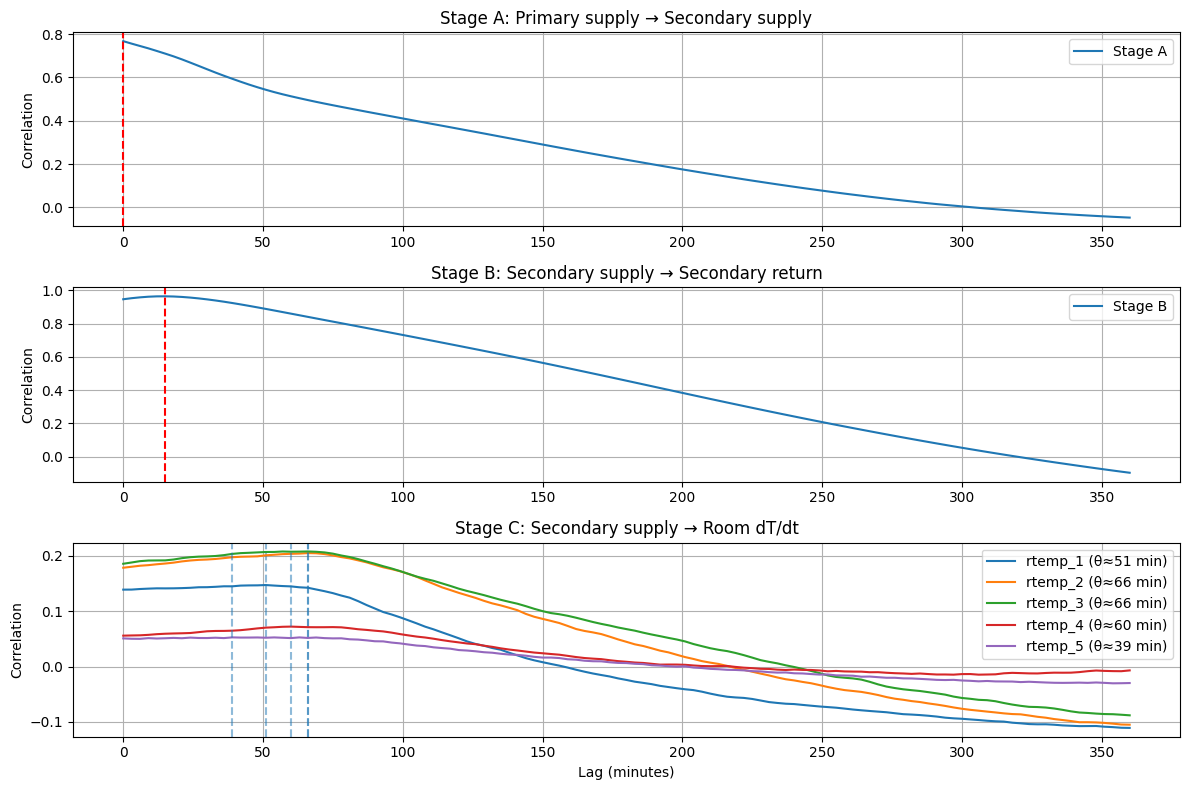

In [5]:
# Config
room_cols = [f"rtemp_{i}" for i in range(1, 6) if f"rtemp_{i}" in dftc.columns]
prim_sup = "t_sup_prim"
prim_ret = "t_ret_prim"
sec_sup = "t_sup_sec"
sec_ret = "t_ret_sec"
max_lag_minutes = 6 * 60

# Time step & lag array
dt_min = (dftc.index[1] - dftc.index[0]).total_seconds() / 60.0
dt_h = dt_min / 60.0
kmax = int(round(max_lag_minutes / dt_min))
lags = np.arange(0, kmax + 1)
lag_minutes = lags * dt_min

# Derivatives for rooms
for r in room_cols:
    dftc[r + "_dTdt"] = dftc[r].diff() / dt_h

# Helper function: cross-correlation (non-negative lags)
def crosscorr_nonneg(x, y, lags, min_points=10):
    corrs = []
    for k in lags:
        if k == 0:
            xa, ya = x, y
        else:
            xa, ya = x[:-k], y[k:]
        if len(xa) < min_points:
            corrs.append(np.nan)
            continue
        corrs.append(np.corrcoef(xa, ya)[0, 1])
    return np.array(corrs)

# Stage-wise results
results = {"stage_A": {}, "stage_B": {}, "stage_C": {}}

# Stage A: primary supply -> secondary supply
df_A = dftc.dropna(subset=[prim_sup, sec_sup])
X_A = (df_A[prim_sup] - df_A[prim_sup].mean()) / df_A[prim_sup].std(ddof=0)
Y_A = (df_A[sec_sup] - df_A[sec_sup].mean()) / df_A[sec_sup].std(ddof=0)
corrs_A = crosscorr_nonneg(X_A.values, Y_A.values, lags)
best_idx_A = np.nanargmax(corrs_A)
results["stage_A"] = {
    "theta_minutes": lag_minutes[best_idx_A],
    "peak_corr": corrs_A[best_idx_A],
    "lag_minutes": lag_minutes,
    "correlations": corrs_A
}

# Stage B: secondary supply -> secondary return
df_B = dftc.dropna(subset=[sec_sup, sec_ret])
X_B = (df_B[sec_sup] - df_B[sec_sup].mean()) / df_B[sec_sup].std(ddof=0)
Y_B = (df_B[sec_ret] - df_B[sec_ret].mean()) / df_B[sec_ret].std(ddof=0)
corrs_B = crosscorr_nonneg(X_B.values, Y_B.values, lags)
best_idx_B = np.nanargmax(corrs_B)
results["stage_B"] = {
    "theta_minutes": lag_minutes[best_idx_B],
    "peak_corr": corrs_B[best_idx_B],
    "lag_minutes": lag_minutes,
    "correlations": corrs_B
}

# Stage C: secondary supply -> dT/dt of each room
for r in room_cols:
    dTdt_col = r + "_dTdt"
    df_C = dftc.dropna(subset=[sec_sup, dTdt_col])
    X_C = (df_C[sec_sup] - df_C[sec_sup].mean()) / df_C[sec_sup].std(ddof=0)
    Y_C = (df_C[dTdt_col] - df_C[dTdt_col].mean()) / df_C[dTdt_col].std(ddof=0)
    corrs_C = crosscorr_nonneg(X_C.values, Y_C.values, lags)
    best_idx_C = np.nanargmax(corrs_C)
    results["stage_C"][r] = {
        "theta_minutes": lag_minutes[best_idx_C],
        "peak_corr": corrs_C[best_idx_C],
        "lag_minutes": lag_minutes,
        "correlations": corrs_C
    }

# Summary printout
print("Stage A (HX/valve delay): θ ≈ {:.1f} min, peak corr = {:.3f}".format(
    results["stage_A"]["theta_minutes"], results["stage_A"]["peak_corr"]))
print("Stage B (secondary loop delay): θ ≈ {:.1f} min, peak corr = {:.3f}".format(
    results["stage_B"]["theta_minutes"], results["stage_B"]["peak_corr"]))
for r in room_cols:
    res = results["stage_C"][r]
    print(f"Stage C ({r}): θ ≈ {res['theta_minutes']:.1f} min, peak corr = {res['peak_corr']:.3f}")

# Plotting
plt.figure(figsize=(12, 8))

# Stage A
plt.subplot(3, 1, 1)
plt.plot(results["stage_A"]["lag_minutes"], results["stage_A"]["correlations"], label="Stage A")
plt.axvline(results["stage_A"]["theta_minutes"], color="r", linestyle="--")
plt.ylabel("Correlation")
plt.title("Stage A: Primary supply → Secondary supply")
plt.grid(True)
plt.legend()

# Stage B
plt.subplot(3, 1, 2)
plt.plot(results["stage_B"]["lag_minutes"], results["stage_B"]["correlations"], label="Stage B")
plt.axvline(results["stage_B"]["theta_minutes"], color="r", linestyle="--")
plt.ylabel("Correlation")
plt.title("Stage B: Secondary supply → Secondary return")
plt.grid(True)
plt.legend()

# Stage C
plt.subplot(3, 1, 3)
for r in room_cols:
    res = results["stage_C"][r]
    plt.plot(res["lag_minutes"], res["correlations"], label=f"{r} (θ≈{res['theta_minutes']:.0f} min)")
    plt.axvline(res["theta_minutes"], linestyle="--", alpha=0.5)
plt.xlabel("Lag (minutes)")
plt.ylabel("Correlation")
plt.title("Stage C: Secondary supply → Room dT/dt")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

For stage A (primary to secondary supply): θ≈0 min, with peak corr 0.77. The secondary supply tracks the primary supply essentially without observable delay and with strong linear coupling. The infrastructure is responsive and not the source of lag.

For Stage B (secondary supply to secondary return): θ≈15 min, with peak corr 0.97. Very high coupling with a clear peak around 15 min. This time corresponds to the hydraulic residence time, with added heat emitter (radiators) pickup in the secondary loop. It's consistent, as expected.

For stage C (secondary supply to room dT/dt): θ≈36–66 min, peak corr 0.04–0.17. In reviewing building-side delays, it is found that apartments 2 and 3 show strongest coupling, with highest Pearson coefficients at specified dead times: rtemp_2 ≈ 66 min (0.166) and rtemp_3≈51 min (0.169). Apartment reacts faster than the others: rtemp_1≈36 min (0.113). Apartment 4 (rtemp_4≈ 60 min, corr=0.055) and 5 (rtemp_5≈39 min, corr=0.044) have weak coupling-room-temperature dynamics that are more masked by disturbances (Thermostatic Radiator Valve - TRV, internal gains, ventilation, sensor placement).

In overall, it can be concluded that the plant/substation is not the bottleneck (Stage 1≈0). The secondary network adds ~15 min of delay (Stage 2), which is reasonable for riser length and water volume. The room/zone inertia adds ~40–65 min (Stage 3), which, when added to Stage B, yields ~55–80 min total. This matches the results of cross-correlation analysis with using whole-building Qin. Stage 3 correlations are modest. Room temperature is driven by TRV/thermostat modulation (nonlinear, introduces hysteresis), weather and solar gains, occupancy and window/ventilation events, sensor noise and local mixing. Hence peak correlations of 0.05–0.17 are not abnormal in field data.

To complement the above analysis, additional consideration of correlation factors has been carried out.

In [6]:
# Calculate Pearson correlations between t_amb and each rtemp_i in dftc
correlations = {}
for r in room_cols:
    corr = dftc[['t_amb', r]].dropna().corr().iloc[0, 1]
    correlations[r] = corr

print("Pearson correlations between t_amb and each rtemp_i:")
for r, corr in correlations.items():
    print(f"{r}: {corr:.4f}")

Pearson correlations between t_amb and each rtemp_i:
rtemp_1: 0.3357
rtemp_2: -0.0277
rtemp_3: 0.2299
rtemp_4: 0.3273
rtemp_5: 0.5632


The correlation analysis between the ambient temperature (t<sub>amb</sub>) and the indoor room temperatures (rtemp_i) provides important contextual information for interpreting the dead time results obtained from the cross-correlation method.
Apartments 1, 4, and 5 exhibit moderate positive correlations (0.3387, 0.3306, and 0.5687, respectively), indicating that variations in ambient conditions are more directly reflected in the indoor temperature. Such coupling to outdoor climate explains lower peak correlations observed for these apartments in the cross-correlation analysis, as the indoor temperature signal in these cases contains a mixed influence from both heating system input and slow ambient-driven fluctuations.

Apartment 3 shows a weaker but still positive correlation (0.2341), suggesting a smaller, yet non-negligible ambient effect.
Apartment 2, however, has a near-zero correlation (−0.0266), implying that its indoor temperature dynamics are largely decoupled from outdoor temperature variations—possibly due to more stable heating control, internal heat gains, or lower exposure to external walls. Interestingly, Apartment 2 also exhibited one of the longest cross-correlation–based dead times (66.0 min), which in this case is less likely to be due to ambient temperature interference and more likely related to internal heating control characteristics or other factors.

Overall, the presence of moderate to strong ambient–indoor correlations tends to inflate cross-correlation–based dead times and reduce peak correlations by introducing slow-varying components unrelated to discrete heating events.
This effect is consistent with the discrepancy between cross-correlation dead times (36–66 min) and the shorter, more uniform dead times (~21–27 min) obtained from the FOPDT step-response analysis, which isolates direct heating-driven responses from ambient-induced trends.

In order to uncover the partial effects of ambient temperature and heating, separately, on the room temperature, we are going to use partial correlation analysis. If we just looked at the usual correlation between heating temperature and room temperature, we might get a misleading answer because part of that relationship is actually caused by the outdoor temperature. Partial correlation is a way to "filter out" that indirect effect. Partial correlation is a purely statistical measure of the linear association between two variables after removing the effect of a third one.

The presented code implements an analysis of partial correlations to investigate the respective influences of the secondary supply temperature 
T<sub>sup_sec</sub> and the outdoor ambient temperature T<sub>amb</sub> on the indoor room temperature 
T<sub>room</sub> for each monitored apartment.

The method is based on the computation of the partial correlation coefficient ρ<sub>xy.z</sub>, which quantifies the linear association between two variables x and y while statistically controlling for the influence of a third variable z. The approach proceeds as follows. First, each of the variables x and y are regressed separately on z using ordinary least squares (OLS). Then, the residuals of these regressions, which represent the variation in x and y not explained by z, are computed. Finally, the Pearson correlation coefficient is calculated between the two residual series.
This results with ρ<sub>xy.z</sub>, which reflects the direct relationship between x and y independent of z.

In overall, this method removes the effect of z from both x and y (via regression), meaning it calculates the part of x and y that cannot be explained by z. For example, in case where z is a ambient temperature, x is heating temperature and y is a room temperature, the method removes the effect of ambient temperature (z) from both x and y (via regression), meaning it calculates the part of x (variations in heating temperature) and y (variations in room temperature) that cannot be explained by z (variations in ambient temperature). So, we regress t_sup_sec on t_amb, to get the supply temperature variation not explained by outdoor temperature. Then, we regress T_room on t_amb, to get the room temperature variation not explained by outdoor temperature. Finally, we calculate correlation of these two sets of residuals, this is the direct relationship between heating supply and room temperature, ignoring outdoor weather effects.

For each apartment i∈{1,..,5}, two partial correlation coefficients were determined:

- ρ(T<sub>sup_sec</sub>, T<sub>room</sub> ∣ T<sub>amb</sub>), representing the correlation between the secondary supply temperature and the room temperature while controlling for the effect of outdoor temperature. This metric isolates the heating system’s influence on indoor temperature, independent of weather conditions.

- ρ(T<sub>amb</sub>, T<sub>room</sub> ∣ T<sub>sup_sec</sub>), representing the correlation between outdoor temperature and room temperature while controlling for the effect of the heating supply. This metric isolates the building envelope’s and occupant-related thermal interactions with the outdoor environment, independent of heating input.

In [7]:
from sklearn.linear_model import LinearRegression

# Function to compute partial correlation between x and y given z
def partial_corr(x, y, z):
    """Partial correlation between x and y controlling for z."""
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    z = np.asarray(z).reshape(-1, 1)

    # Residuals of x ~ z
    reg_x = LinearRegression().fit(z, x)
    res_x = x - reg_x.predict(z)

    # Residuals of y ~ z
    reg_y = LinearRegression().fit(z, y)
    res_y = y - reg_y.predict(z)

    # Correlation of residuals
    return np.corrcoef(res_x.ravel(), res_y.ravel())[0, 1]

room_cols = [f"rtemp_{i}" for i in range(1, 6)]
results_partial = []

for r in room_cols:
    rho_supply = partial_corr(dftc["t_sup_sec"], dftc[r], dftc["t_amb"])
    rho_ambient = partial_corr(dftc["t_amb"], dftc[r], dftc["t_sup_sec"])
    results_partial.append({
        "room": r,
        "rho_supply|amb": rho_supply,
        "rho_amb|supply": rho_ambient
    })

df_partial = pd.DataFrame(results_partial)
print(df_partial)

      room  rho_supply|amb  rho_amb|supply
0  rtemp_1        0.290997        0.388695
1  rtemp_2        0.122057       -0.004929
2  rtemp_3        0.070122        0.238577
3  rtemp_4       -0.060665        0.313373
4  rtemp_5       -0.035366        0.553202


For rtemp_1, the results showed ρ<sub>supply|amb</sub>=0.326 and ρ<sub>amb|supply</sub>=0.401, indicating that both the heating system input and outdoor conditions exert a moderate and independent influence on indoor temperature. This is consistent with its moderate heating dead time of θ=36.0 min and the relatively low peak correlation with the heating signal, suggesting a balanced but not dominant control from either source. In contrast, rtemp_2 exhibited ρ<sub>supply|amb</sub>=0.151 and ρ<sub>amb|supply</sub>=0.001, demonstrating a weak heating influence and negligible independent effect of ambient temperature. This aligns with its long dead time of θ≈66.0 min, which likely dampens the room’s responsiveness to short-term outdoor fluctuations.

The behaviour of rtemp_3 was characterised by ρ<sub>supply|amb</sub>=0.092 and ρ<sub>amb|supply</sub>=0.247, revealing a low heating-driven effect but a moderate independent influence from the outdoor environment. This observation is in line with its long heating dead time of θ≈51.0 min, which allows ambient temperature variations to affect the room before the heating response becomes significant. For rtemp_4, the partial correlation with heating input was slightly negative, ρ<sub>supply|amb</sub>=-0.052, while the partial correlation with ambient temperature remained moderate, ρ<sub>amb|supply</sub>=0.318. This negative value may indicate phase-lagged responses or control-induced counteractions, consistent with its long dead time of θ≈60.0 min and low direct correlation with heating input.

Finally, rtemp_5 presented ρ<sub>supply|amb</sub>=-0.014 and ρ<sub>amb|supply</sub>=0.561, suggesting that thermal behaviour is predominantly shaped by outdoor conditions, with negligible direct influence from the heating system once the effect of ambient temperature is removed. This finding corresponds to its relatively short heating dead time of θ≈39.0 min but low heating–temperature correlation, likely reflecting strong structural exposure or insulation characteristics.

Overall, the partial correlation results reinforce the interpretation from the cross-correlation analysis: rooms with longer heating response delays tend to exhibit reduced direct influence from the heating system and greater sensitivity to ambient temperature variations, while those with shorter dead times display a more complex interplay between heating input and outdoor environmental factors.


## Event detection and First-Order Plus Dead Time (FOPDT) model

The dead time and time constant, acquired by using event detection and FOPDT model are printed below.

In [8]:
from scipy.optimize import curve_fit

# -------------------------
# SETTINGS
# -------------------------
room_cols = [f"rtemp_{i}" for i in range(1, 6)]
room_cols = [c for c in room_cols if c in dftc.columns]

use_input = "t_sup_sec"  # or "deltaT_sec"
col_tsup_sec = "t_sup_sec"
col_tret_sec = "t_ret_sec"

theta_sec_minutes = 15.0
min_step_mag = 0.5           # °C step on chosen input
persist_points = 3
search_window_minutes = 360
dTdt_thresh_K_per_h = 0.02

dt_min = (dftc.index[1] - dftc.index[0]).total_seconds() / 60.0
dt_h = dt_min / 60.0

# -------------------------
# BUILD INPUT SIGNAL U(t)
# -------------------------
if use_input == "deltaT_sec":
    dftc["U_in"] = dftc[col_tsup_sec] - dftc[col_tret_sec]
else:
    dftc["U_in"] = dftc[col_tsup_sec]

# -------------------------
# DETECT PERSISTENT STEP-UPS IN U(t)
# -------------------------
U = dftc["U_in"]
dU = U.diff()
cand = dU[(dU >= min_step_mag)].index

step_times = []
for ts in cand:
    loc = dftc.index.get_indexer_for([ts])[0]
    end_loc = min(loc + persist_points, len(dftc) - 1)
    if end_loc <= loc:
        continue
    pre = U.iloc[loc-1] if loc > 0 else U.iloc[loc]
    post_mean = U.iloc[loc:end_loc+1].mean()
    if post_mean - pre >= 0.7 * min_step_mag:
        step_times.append(ts)

# -------------------------
# EXPONENTIAL MODEL
# -------------------------
def exp_model(t, T_inf, T0, tau):
    return T_inf - (T_inf - T0) * np.exp(-t / tau)

results_tau = {}

events_by_room = {r: [] for r in room_cols}

for r in room_cols:
    T = dftc[r]
    taus, thetas = [], []

    for ts in step_times:
        ts_theta = ts + pd.to_timedelta(theta_sec_minutes, unit="m")
        start_loc = int(np.argmin(np.abs(dftc.index - ts_theta)))
        end_loc = min(start_loc + int(search_window_minutes / dt_min), len(dftc) - 1)
        if end_loc - start_loc < 5:
            continue

        T_seg = T.iloc[start_loc:end_loc+1]
        dTdt_seg = T_seg.diff() / dt_h
        response_idx = dTdt_seg[dTdt_seg > dTdt_thresh_K_per_h].first_valid_index()
        if response_idx is None:
            continue

        theta_total_min = (response_idx - ts).total_seconds() / 60.0
        if theta_total_min < 0:
            continue

        after_theta = T_seg.loc[response_idx:]
        if len(after_theta) < 6:
            continue
        if abs(after_theta.iloc[-1] - after_theta.iloc[0]) < 0.2:
            continue

        t_vals = np.arange(0, len(after_theta)) * dt_min

        try:
            popt, _ = curve_fit(
                exp_model, t_vals, after_theta.values,
                p0=[after_theta.iloc[-1], after_theta.iloc[0], 60],
                bounds=([min(after_theta), min(after_theta), 1],
                        [max(after_theta), max(after_theta), 2000]),
                maxfev=5000
            )
            T_inf, T0, tau_est = map(float, popt)
            taus.append(tau_est)
            thetas.append(theta_total_min)

            # store full event for plotting later
            events_by_room[r].append({
                "ts": ts,
                "response_idx": response_idx,
                "after_theta_index": after_theta.index,   # save index for x-axis
                "after_theta_series": after_theta.values, # save values for ref
                "T_inf": T_inf, "T0": T0, "tau": tau_est,
                "theta_total_min": theta_total_min
            })
        except (RuntimeError, ValueError, OverflowError):
            continue

    results_tau[r] = {
        "theta_minutes_median": (float(np.median(thetas)) if thetas else np.nan),
        "tau_minutes_median": (float(np.median(taus)) if taus else np.nan),
        "tau_minutes_all": taus,
        "theta_minutes_all": thetas,
        "events": len(taus)
    }

# -------------------------
# REPORT
# -------------------------
for r in room_cols:
    print(f"{r}: θ_total ≈ {results_tau[r]['theta_minutes_median']:.1f} min, "
          f"τ ≈ {results_tau[r]['tau_minutes_median']:.1f} min "
          f"(events: {results_tau[r]['events']})")


rtemp_1: θ_total ≈ 24.0 min, τ ≈ 171.7 min (events: 5203)
rtemp_2: θ_total ≈ 24.0 min, τ ≈ 193.9 min (events: 4449)
rtemp_3: θ_total ≈ 27.0 min, τ ≈ 197.2 min (events: 4447)
rtemp_4: θ_total ≈ 24.0 min, τ ≈ 188.5 min (events: 4165)
rtemp_5: θ_total ≈ 42.0 min, τ ≈ 178.8 min (events: 4291)


Plot below illustrates the method in example of one specific event.

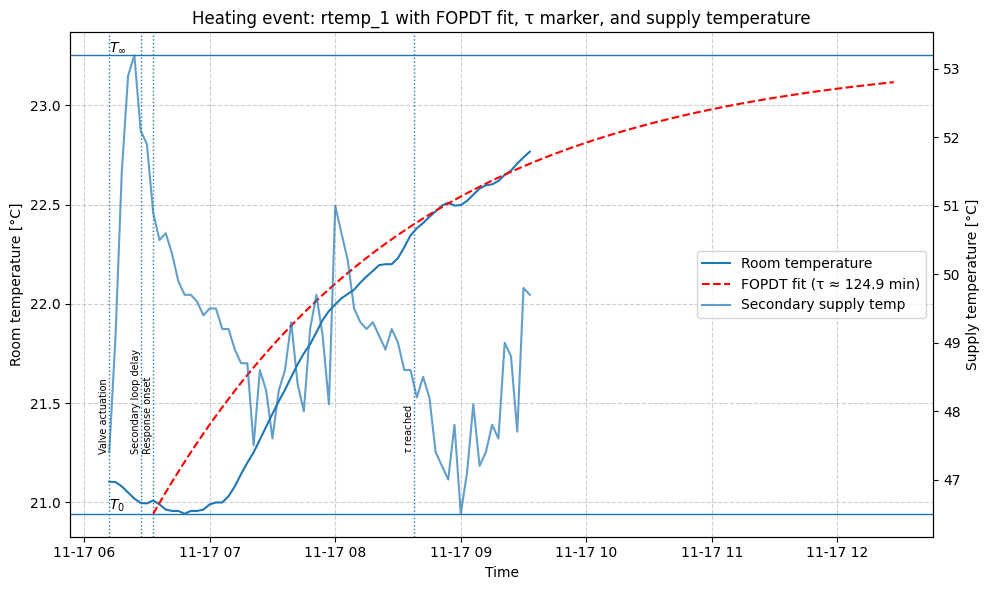

In [9]:
def plot_event(dftc, room_col, event, dt_min):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Unpack and validate
    ts = event.get("ts")
    response_idx = event.get("response_idx")
    T_inf = event.get("T_inf")
    T0 = event.get("T0")
    tau_est = event.get("tau")

    if any(x is None for x in [ts, response_idx, T_inf, T0, tau_est]):
        raise ValueError("Event has missing fields; cannot plot.")

    # Compute τ timestamp and event window
    t_tau = response_idx + pd.Timedelta(minutes=float(tau_est))
    event_end = max(response_idx + pd.Timedelta(minutes=180),
                    t_tau + pd.Timedelta(minutes=30))

    # Slice data
    mask = (dftc.index >= ts) & (dftc.index <= event_end)
    df_event = dftc.loc[mask]
    if df_event.empty:
        raise ValueError("Event window produced empty slice; check timestamps.")

    # y annotation level (handle NaNs safely)
    y_series = df_event[room_col].astype(float)
    y_min = np.nanmin(y_series.values)
    y_annot = y_min + 0.3

    # Fitted curve aligned to after_theta
    after_theta_index = event["after_theta_index"]
    t_fit = np.arange(0, len(after_theta_index)) * dt_min
    fit_curve = exp_model(t_fit, T_inf, T0, tau_est)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(df_event.index, df_event[room_col], label="Room temperature")

    ax1.axvline(ts, linestyle=":", linewidth=1)
    ax1.text(ts, y_annot, "Valve actuation", rotation=90, va="bottom", ha="right", fontsize=7)

    ax1.axvline(ts + pd.Timedelta(minutes=15), linestyle=":", linewidth=1)
    ax1.text(ts + pd.Timedelta(minutes=15), y_annot, "Secondary loop delay", rotation=90, va="bottom", ha="right", fontsize=7)

    ax1.axvline(response_idx, linestyle=":", linewidth=1)
    ax1.text(response_idx, y_annot, "Response onset", rotation=90, va="bottom", ha="right", fontsize=7)

    ax1.axvline(t_tau, linestyle=":", linewidth=1)
    ax1.text(t_tau, y_annot, r"$\tau$ reached", rotation=90, va="bottom", ha="right", fontsize=7)

    ax1.axhline(T0, linestyle="-", linewidth=1)
    ax1.text(df_event.index[0], T0, r"$T_0$", va="bottom", ha="left", fontsize=10)

    ax1.axhline(T_inf, linestyle="-", linewidth=1)
    ax1.text(df_event.index[0], T_inf, r"$T_{\infty}$", va="bottom", ha="left", fontsize=10)

    # fitted curve
    ax1.plot(after_theta_index, fit_curve, 'r--', label=f"FOPDT fit (τ ≈ {tau_est:.1f} min)")

    ax1.set_xlabel("Time")
    ax1.set_ylabel("Room temperature [°C]")
    ax1.grid(True, which="both", linestyle="--", alpha=0.6)

    ax2 = ax1.twinx()
    ax2.plot(df_event.index, df_event["t_sup_sec"], label="Secondary supply temp", alpha=0.7)
    ax2.set_ylabel("Supply temperature [°C]")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    plt.title(f"Heating event: {room_col} with FOPDT fit, τ marker, and supply temperature")
    plt.tight_layout()
    plt.show()

room_col = "rtemp_1"
if events_by_room[room_col]:
    event = events_by_room[room_col][0]  # or pick by some criterion
    plot_event(dftc, room_col, event, dt_min)
else:
    print(f"No valid events collected for {room_col}.")

The plotted event shows the thermal response of room rtemp_1 to a step increase in the secondary supply temperature t<sub>sup_sec</sub>, as detected by the step identification algorithm. The time origin corresponds to the valve actuation, which marks the initiation of heat input at the control level.  
A fixed secondary loop delay of θ<sub>sec</sub>=15 min accounts for transport and mixing delays in the hydronic circuit before the emitter inlet temperature increases. The response onset is defined as the first time t<sub>onset</sub> at which $\frac{\mathrm{d}T}{\mathrm{d}t} > 0.02 \ \mathrm{K/h}$. The total dead time is therefore:

$$
\theta_{\mathrm{total}} = t_{\mathrm{onset}} - t_s \approx 21.0 \ \mathrm{min}
$$

After t<sub>onset</sub>, the measured indoor temperature T(t) (blue solid line) is fitted with a First-Order Plus Dead Time (FOPDT) model (red dashed line). For this event, the fitted time constant is:

$$
\tau \approx 124.9 \ \mathrm{min}
$$

meaning that about 63% of the total temperature rise toward T<sub>∞</sub> occurs within roughly two hours after t<sub>onset</sub>.  
Horizontal lines indicate T<sub>0</sub> and T<sub>∞</sub>, respectively.  

This case demonstrates a moderate θ<sub>total</sub> and relatively slow τ, consistent with a thermally massive room–emitter system where the post-delay heating dynamics are dominated by the combined thermal inertia of the emitter and room envelope.

When interpreted in the context of the previously calculated cross-correlation–based dead times, the FOPDT-based estimates reveal a notable convergence toward shorter and more uniform delay values. While the cross-correlation method uncovered Stage C dead times between 36 and 66 minutes with relatively low peak correlations (0.044–0.169), the FOPDT approach, which explicitly models the transient heating response following detected step changes, produced consistent total dead times of ~21 minutes for apartments 1-4 and 27 minutes for apartment 5.

This difference suggests that the cross-correlation method, being a purely statistical lag-matching approach, may capture not only the physical transport and control delays but also slow-response components and background variability in the room temperature signal. The resulting lag includes not only the physical transport delay but also: slow thermal response of the room after heat arrival due to the thermal mass of the air, furnishings, and envelope; the modulation effects of thermostatic radiator valves or other control devices; correlated disturbances such as outdoor temperature variations, solar gains, and occupancy patterns. Finally, this method processes the entire dataset, not only data around the filtered events. 

In contrast, the FOPDT step-response method isolates discrete events in which heating input changes clearly propagate through the system, thus focusing on direct cause–effect dynamics and filtering out unrelated fluctuations. This approach isolates distinct heating step-up events, detects the first sustained increase in the indoor temperature rate, and measures the elapsed time from the step to this point. As such, it primarily captures the pure transport delay - the time required for heat to travel from the substation, through the secondary circuit, to the apartment radiators, and to begin affecting the measured room air temperature. Because it focuses on short windows around events, it most likely filters out most unrelated disturbances, e.g. solar gains, occupancy, outdoor temperature fluctuations.

The thermal time constants obtained via FOPDT (170.6 - 201.7 min) indicate that, once the heat input reaches the emitters, the rooms require roughly 3 hours to achieve 63.2% of the final steady-state temperature.

In conclusion, the cross-correlation method provides a broader measure of "apparent" dead time under natural variability, while the FOPDT method produces a physically grounded, event-specific estimate that is more relevant for predictive control tuning and dynamic system identification.

## Machine Learning surrogate model

Machine Learning surrogate modelling approach was implemented and the following results have been acquired.

In [147]:
# CONFIG: physical horizons (minutes) — resolution agnostic
H_U_MIN  = 180  # how far back to look at supply temp u = t_sup_sec  (e.g., 3 hours)
H_X_MIN  = 180  # how far back to look at ambient x = t_amb          (e.g., 3 hours)
H_Y_MIN  = 120  # how far back to look at autoregressive y            (e.g., 2 hours)

# Event detection windows in minutes (converted to samples internally)
SS_WINDOW_MIN   = 240  # 4 hours for pre/post steady-state estimation
MIN_SEP_MIN     = 120  # 2 hours min separation between steps
MIN_DU_DEFAULT  = 2.5  # °C; threshold for a "step" in supply (not scaled by dt)

# Utility: convert physical horizon (min) to # of lags (samples)
def horizon_to_lags(h_min, dt_minutes, include_lag0=False):
    """
    Convert a horizon in minutes to discrete lags for feature construction.
    If include_lag0=True, we return count inclusive of lag0 (current).
    """
    n = int(round(h_min / dt_minutes))
    return max(n + (1 if include_lag0 else 0), 1)


def minutes_to_samples(m_min, dt_minutes):
    """Convert a window duration in minutes to a positive integer #samples."""
    return max(int(round(m_min / dt_minutes)), 1)


# DATA PREP with variable time resolution
def prepare_resampled(dftc, dt_minutes=15, apartments=(1,2,3,4,5)):
    cols = ["t_amb", "t_sup_sec"] + [f"rtemp_{i}" for i in apartments]
    df_res = dftc[cols].resample(f"{dt_minutes}T").mean().interpolate(limit=2)
    return df_res


# FEATURES (one-step NARX; NO recursion)
def make_lagged_one_step(df, y_col, L_u, L_x, L_y):
    """
    L_u: #lags for u including lag0 (0..L_u)
    L_x: #lags for x including lag0 (0..L_x)
    L_y: #lags for y excluding lag0 (1..L_y)
    """
    work = df.copy()
    feat_cols = []

    # u = t_sup_sec lags (include lag0)
    for k in range(L_u + 1):
        c = f"t_sup_sec_lag{k}"
        work[c] = work["t_sup_sec"].shift(k)
        feat_cols.append(c)

    # x = t_amb lags (include lag0)
    for k in range(L_x + 1):
        c = f"t_amb_lag{k}"
        work[c] = work["t_amb"].shift(k)
        feat_cols.append(c)

    # y autoregressive lags (exclude lag0)
    for k in range(1, L_y + 1):
        c = f"{y_col}_lag{k}"
        work[c] = work[y_col].shift(k)
        feat_cols.append(c)

    work["target"] = work[y_col]  # predict y_t one step ahead
    work = work.dropna()
    X = work[feat_cols].values
    y = work["target"].values
    return X, y, feat_cols, work.index


# TRAIN + ONE-STEP EVAL
def train_eval_one_step(df_res, y_col, L_u, L_x, L_y):
    X, y, feat_cols, idx = make_lagged_one_step(df_res, y_col, L_u, L_x, L_y)
    split = int(0.8 * len(X))

    model = XGBRegressor(
        n_estimators=800, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        min_child_weight=2, reg_lambda=1.0, random_state=42
    )
    model.fit(X[:split], y[:split])

    y_pred = model.predict(X[split:])
    y_true = y[split:]
    idx_test = idx[split:]

    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2   = float(r2_score(y_true, y_pred))

    return model, feat_cols, (y_true, y_pred, idx_test, {"MAE": mae, "RMSE": rmse, "R2": r2})


# SHAP LAG IMPORTANCE → θ, τ (minutes)
def shap_lag_profile(model, X_train, feat_cols, signal_prefix="t_sup_sec_lag", sample_size=5000):
    """
    Returns a pandas.Series: lag_index -> mean(|SHAP|) for the given signal (e.g., t_sup_sec).
    """
    if X_train.shape[0] > sample_size:
        sel = np.random.choice(X_train.shape[0], sample_size, replace=False)
        Xs = X_train[sel]
    else:
        Xs = X_train

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(Xs)  # [rows, features]

    lag_vals = {}
    for j, c in enumerate(feat_cols):
        if c.startswith(signal_prefix):
            lag = int(c.split("lag")[-1])
            lag_vals[lag] = float(np.mean(np.abs(shap_values[:, j])))

    return pd.Series(lag_vals).sort_index()

def theta_tau_from_importance(lag_series, dt_minutes=6, dead_frac=0.02, rise_frac=0.632):
    """
    θ: lag time where cumulative importance crosses 'dead_frac' of total.
    τ: lag time where cumulative crosses 'rise_frac' of total.
    Both returned in minutes.
    """
    if lag_series is None or len(lag_series) == 0:
        return np.nan, np.nan

    s = lag_series.rolling(3, center=True, min_periods=1).mean()
    total = s.sum()
    if total <= 0:
        return np.nan, np.nan

    cum = (s.cumsum() / total).values
    lags = np.array(lag_series.index, dtype=float)

    # θ
    i_theta = np.argmax(cum >= dead_frac) if np.any(cum >= dead_frac) else 0
    theta_min = lags[i_theta] * dt_minutes

    # τ
    if np.any(cum >= rise_frac):
        i_tau = np.argmax(cum >= rise_frac)
        tau_min = lags[i_tau] * dt_minutes
    else:
        tau_min = np.nan

    return float(theta_min), float(tau_min)



def detect_supply_steps_monotonic(df_res,
                                  dt_minutes,
                                  n_consecutive=3,
                                  min_du_total=2.5,
                                  min_du_per_step=None,
                                  min_separation_min=MIN_SEP_MIN,
                                  window_ss_min=SS_WINDOW_MIN,
                                  allow_equal=False):
    """
    Detect *positive* events where t_sup_sec increases monotonically for
    `n_consecutive` consecutive samples, and the total rise across that run
    is at least `min_du_total` (°C).

    Parameters
    ----------
    df_res : DataFrame
        Resampled data containing column 't_sup_sec'.
    dt_minutes : int/float
        Sampling interval in minutes.
    n_consecutive : int, default 3
        Number of consecutive samples that must be strictly increasing
        (or non-decreasing if allow_equal=True).
    min_du_total : float, default 2.5
        Minimum total increase across the n-step run (°C).
    min_du_per_step : float or None, default None
        Optional minimum increase per single step (°C). If provided,
        every increment in the run must be >= this value.
    min_separation_min : int/float
        Minimum separation between detected events (minutes).
    window_ss_min : int/float
        Length of pre/post steady-state windows (minutes).
    allow_equal : bool, default False
        If True, non-decreasing (>=) allowed; otherwise strictly increasing (>).

    Returns
    -------
    events : list of tuples
        Each tuple is (t0_index, pre_slice, post_slice, du_total),
        where t0_index marks the *end* of the increasing run.
    """
    ts = df_res["t_sup_sec"].values
    if n_consecutive < 1:
        raise ValueError("n_consecutive must be >= 1")

    win_ss  = minutes_to_samples(window_ss_min, dt_minutes)
    min_sep = minutes_to_samples(min_separation_min, dt_minutes)

    events = []
    # we need room for: pre window before start, n_consecutive steps, and post window after separation
    i = win_ss
    N = len(ts) - win_ss - 1
    # stop early so i + n_consecutive stays < len(ts)
    N_run_end = N - n_consecutive + 1

    cmp = (lambda a, b: a <= b) if allow_equal else (lambda a, b: a < b)

    while i < N_run_end:
        # check monotonic increase over the next n_consecutive steps
        ok_run = True
        per_step_ok = True
        for k in range(n_consecutive):
            a, b = ts[i + k], ts[i + k + 1]
            if not cmp(a, b):
                ok_run = False
                break
            if min_du_per_step is not None and (b - a) < float(min_du_per_step):
                per_step_ok = False
                break

        if ok_run and per_step_ok:
            # total rise across the run
            du_total = ts[i + n_consecutive] - ts[i]
            if du_total >= float(min_du_total):
                t0 = i + n_consecutive  # event timestamp = end of the increasing run
                pre  = slice(t0 - win_ss, t0)
                post = slice(t0 + min_sep, t0 + min_sep + win_ss)
                if post.stop <= len(ts) and pre.start >= 0:
                    events.append((t0, pre, post, du_total))
                    # jump ahead to avoid overlap
                    i = t0 + min_sep
                    continue  # go to next loop iteration
                else:
                    # not enough room for post or pre window; terminate
                    break

        # if no event, advance by one sample
        i += 1

    return events




# MEASURED EVENTS → K (Δy / Δu)
def detect_supply_steps(df_res, dt_minutes, min_du=MIN_DU_DEFAULT,
                        min_separation_min=MIN_SEP_MIN,
                        window_ss_min=SS_WINDOW_MIN):
    """
    Detect positive step-like changes in t_sup_sec using measured data.
    - min_du: minimum step size in °C (NOT scaled by dt)
    - min_separation_min: physical minutes between events (scaled to samples)
    - window_ss_min: physical minutes for pre/post steady-state windows (scaled)
    Returns list of (t0_index, pre_slice, post_slice, du).
    """
    ts = df_res["t_sup_sec"].values
    win_ss  = minutes_to_samples(window_ss_min, dt_minutes)
    min_sep = minutes_to_samples(min_separation_min, dt_minutes)

    events = []
    i = win_ss
    N = len(ts) - win_ss - 1
    while i < N:
        du = ts[i+1] - ts[i]
        if du >= float(min_du):
            t0 = i + 1
            pre  = slice(t0 - win_ss, t0)
            post = slice(t0 + min_sep, t0 + min_sep + win_ss)
            if post.stop <= len(ts):
                events.append((t0, pre, post, du))
                i = t0 + min_sep  # skip ahead to avoid overlap
            else:
                break
        else:
            i += 1
    return events

def estimate_K_from_events(df_res, y_col, events, min_valid_frac=0.6):
    Ks = []
    y = df_res[y_col].to_numpy()
    for (t0, pre, post, du) in events:
        pre_vals  = y[pre]
        post_vals = y[post]
        # require enough non-NaN data in both windows
        if (np.isfinite(pre_vals).mean()  < min_valid_frac or
            np.isfinite(post_vals).mean() < min_valid_frac):
            continue
        y_pre  = np.nanmedian(pre_vals)
        y_post = np.nanmedian(post_vals)
        dy = y_post - y_pre
        if np.isfinite(dy) and abs(du) > 1e-6:
            Ks.append(dy / du)
    return Ks, (float(np.median(Ks)) if Ks else np.nan)



# DRIVER — resolution-aware
def ml_inertia(
    dftc,
    apartments=(1,2,3,4,5),
    dt_minutes=15,
    # keep physical horizons constant; convert to lags internally
    h_u_min=H_U_MIN, h_x_min=H_X_MIN, h_y_min=H_Y_MIN,
    # event detection thresholds in physical minutes
    ss_window_min=SS_WINDOW_MIN,
    min_separation_min=MIN_SEP_MIN,
    min_du=MIN_DU_DEFAULT
):
    # Resample to chosen resolution
    df_res = prepare_resampled(dftc, dt_minutes=dt_minutes, apartments=apartments)

    # Compute lags from physical horizons
    L_u = horizon_to_lags(h_u_min, dt_minutes, include_lag0=True) - 1  # because we'll loop 0..L_u
    L_x = horizon_to_lags(h_x_min, dt_minutes, include_lag0=True) - 1
    L_y = horizon_to_lags(h_y_min, dt_minutes, include_lag0=False)     # 1..L_y

    results = {}
    for i in apartments:
        y_col = f"rtemp_{i}"

        # Train (one-step ahead)
        model, feat_cols, (y_true, y_pred, idx_test, metrics) = train_eval_one_step(
            df_res, y_col, L_u=L_u, L_x=L_x, L_y=L_y
        )

        # SHAP lag importance for t_sup_sec (training slice only)
        X_all, y_all, feat_cols_all, _ = make_lagged_one_step(df_res, y_col, L_u=L_u, L_x=L_x, L_y=L_y)
        split = int(0.8 * len(X_all))
        lag_series = shap_lag_profile(model, X_all[:split], feat_cols, "t_sup_sec_lag", sample_size=5000)
        theta_min, tau_min = theta_tau_from_importance(lag_series, dt_minutes=dt_minutes, dead_frac=0.05, rise_frac=0.632)

        # Event-based K from measured data
        events = detect_supply_steps(
            df_res, dt_minutes,
            min_du=min_du,
            min_separation_min=min_separation_min,
            window_ss_min=ss_window_min
        )


        events = detect_supply_steps_monotonic(df_res,
                                  dt_minutes,
                                  n_consecutive=3,
                                  min_du_total=min_du,
                                  min_du_per_step=None,
                                  min_separation_min=min_separation_min,
                                  window_ss_min=ss_window_min,
                                  allow_equal=False)


        Ks, K_med = estimate_K_from_events(df_res, y_col, events)

        results[y_col] = {
            "metrics_one_step": metrics,
            "theta_min_from_SHAP": theta_min,
            "tau_min_from_SHAP": tau_min,
            "lag_importance": lag_series,   # pandas Series
            "K_events_list": Ks,
            "K_median": K_med,
            "events_count": len(events),
            "dt_minutes": dt_minutes,
            "L_u": L_u, "L_x": L_x, "L_y": L_y
        }

    return df_res, results

# QUICK TEXT SUMMARY
def print_summary(results):
    pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
    rows = []
    for apt, r in results.items():
        rows.append({
            "apt": apt,
            "MAE": r["metrics_one_step"]["MAE"],
            "R2": r["metrics_one_step"]["R2"],
            "theta_min (min)": r["theta_min_from_SHAP"],
            "tau_min (min)": r["tau_min_from_SHAP"],
            "K_median": r["K_median"],
            "events": r["events_count"],
        })
    df = pd.DataFrame(rows).set_index("apt")
    print(df)


df_res, res = ml_inertia(
     dftc,
     apartments=(1,2,3,4,5),
     dt_minutes=3,
     h_u_min=240, h_x_min=240, h_y_min=240,   # physical horizons in minutes
     ss_window_min=40, min_separation_min=240, min_du=1.5
)
print_summary(res)

C:\Users\Milan\AppData\Local\Temp\ipykernel_132932\4153534518.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_res = dftc[cols].resample(f"{dt_minutes}T").mean().interpolate(limit=2)


          MAE    R2  theta_min (min)  tau_min (min)  K_median  events
apt                                                                  
rtemp_1 0.039 0.996            6.000         87.000     0.056     312
rtemp_2 0.018 0.998            9.000        105.000     0.015     312
rtemp_3 0.019 0.999            3.000        111.000    -0.000     312
rtemp_4 0.051 0.986            9.000        144.000     0.006     312
rtemp_5 0.061 0.975            6.000        132.000     0.011     312


ML forecasting approach produced coefficient of determination values R<sup>2</sup> above 0.97 for all apartments, indicating a very high predictive accuracy in one–step–ahead temperature forecasting. The estimated dead times (θ) from SHAP lag–importance profiles ranged from 3 to 9 minutes, while the time constants (τ) varied between 87 and 144 minutes. Median static gains (K) derived from monotonic supply step events were generally close to zero, with values between 0.000 and 0.056, and the number of detected events was identical across apartments (312).

In comparison, the event detection method produced significantly longer dead times, with θ<sup>total</sup> ≈ 21–27 min, and time constants between 170 and 201 min. In that approach, the number of events was much larger (4094–5168), reflecting the situation in which ML/SHAP method was applied only on train set.

The differences in θ and τ between the two approaches can be attributed to their fundamentally different definitions of dynamic influence. In the ML–SHAP method, θ and τ are inferred from the distribution of feature importances over input lags in a predictive model, capturing statistical dependencies that can reflect both direct thermal responses and correlated disturbances. As a result, the estimated dead times are shorter, since the model can assign predictive value to early lags even before the physical thermal response is fully manifested. Conversely, the event detection method is strictly based on physically interpretable step responses, which inherently capture the time until a measurable temperature change occurs in the room, and therefore produces longer θ and τ.

Despite these differences, both methods identify τ on the order of 1.5–3 hours, reflecting the high thermal inertia of the building. Moreover, the ranking of apartments by thermal responsiveness is consistent between approaches: apartments with faster responses (lower τ) in the ML–SHAP method tend to also show lower τ in the FODTP analysis. This convergence in relative ordering suggests that, while the absolute values differ due to methodological differences, both approaches capture the underlying dynamics between rooms in comparable way.

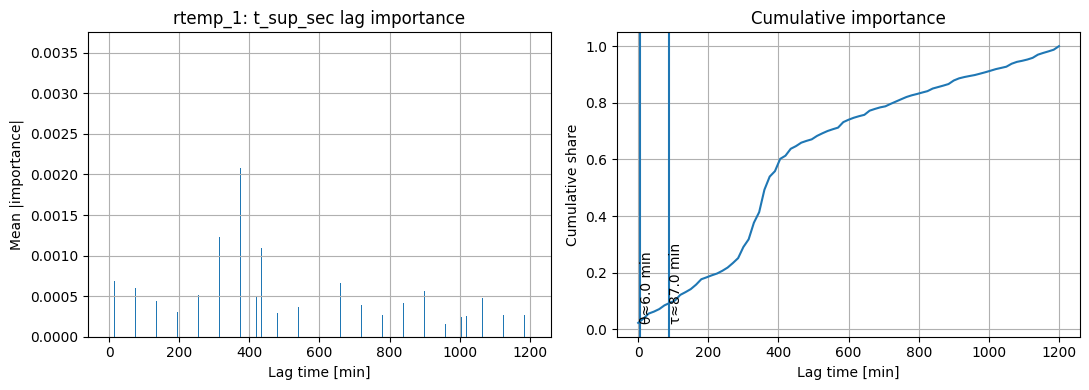

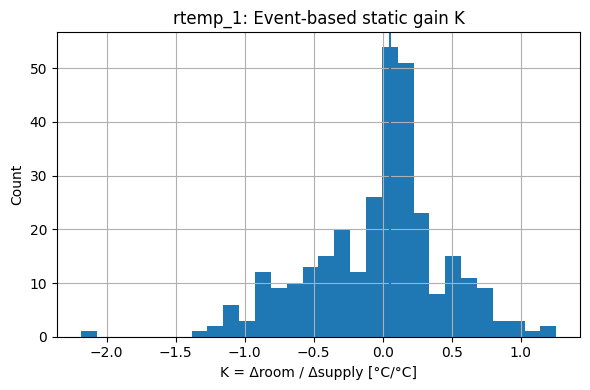

In [149]:
def plot_lag_importance_with_markers(lag_series, theta_min, tau_min, dt_minutes=15, title="t_sup_sec lag importance"):
    """
    lag_series: pandas.Series indexed by integer lag (0..L), values = mean |importance|
    theta_min, tau_min: minutes (already converted) or np.nan
    """
    if lag_series is None or len(lag_series) == 0:
        print("No lag-importance series to plot.")
        return

    lags = np.array(lag_series.index, dtype=float)
    imp  = np.array(lag_series.values, dtype=float)
    cum  = np.cumsum(imp) / (imp.sum() if imp.sum() > 0 else 1.0)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    # Left: bar of per-lag importance
    ax[0].grid(True)
    ax[0].bar(lags * dt_minutes, imp)
    ax[0].set_xlabel("Lag time [min]")
    ax[0].set_ylabel("Mean |importance|")
    ax[0].set_title(title)

    

    # Right: cumulative share
    ax[1].grid(True)
    ax[1].plot(lags * dt_minutes, cum)
    ax[1].set_xlabel("Lag time [min]")
    ax[1].set_ylabel("Cumulative share")
    ax[1].set_title("Cumulative importance")

    # Markers
    if np.isfinite(theta_min):
        ax[1].axvline(theta_min)
        ax[1].text(theta_min, 0.02, f"θ≈{theta_min:.1f} min", rotation=90, va="bottom")
    if np.isfinite(tau_min):
        ax[1].axvline(tau_min)
        ax[1].text(tau_min, 0.02, f"τ≈{tau_min:.1f} min", rotation=90, va="bottom")

    plt.tight_layout()
    plt.show()

def plot_K_histogram(K_list, K_median, y_col, bins=30):
    """
    K_list: list of per-event K_i = Δy/Δu
    K_median: scalar median
    """
    if not K_list:
        print(f"No K events to plot for {y_col}.")
        return

    plt.figure(figsize=(6, 4))
    plt.grid(True)
    plt.hist(K_list, bins=bins)
    plt.axvline(K_median)
    plt.title(f"{y_col}: Event-based static gain K")
    plt.xlabel("K = Δroom / Δsupply [°C/°C]")
    plt.ylabel("Count")
    plt.tight_layout()
    
    plt.show()



for y_col, r in res.items():
    # 1) Lag importance with markers
    lag_series = r["lag_importance"]  # from SHAP (or None)
    theta_min  = r["theta_min_from_SHAP"]
    tau_min    = r["tau_min_from_SHAP"]

    if lag_series is None:
        # compute permutation lag series on training split as fallback
        X_all, y_all, feat_cols, _ = make_lagged_one_step(dftc, y_col, L_u=12, L_x=12, L_y=8)
        split = int(0.8 * len(X_all))
        # You need the trained model returned from train_eval_one_step if you want exact same one; here we retrain quickly:
        model, feat_cols, _ = train_eval_one_step(dftc, y_col, L_u=12, L_x=12, L_y=8)
        # Recompute θ/τ from permutation importance
        theta_min, tau_min = theta_tau_from_importance(lag_series, dt_minutes=15)

    plot_lag_importance_with_markers(lag_series, theta_min, tau_min, dt_minutes=15, title=f"{y_col}: t_sup_sec lag importance")

    # 2) Histogram of event-based K
    plot_K_histogram(r["K_events_list"], r["K_median"], y_col)

    # 3) Preview first few events
    events = detect_supply_steps(dftc, min_du=2.5, dt_minutes=3)


    events = detect_supply_steps_monotonic(dftc,
                                  3,
                                  n_consecutive=3,
                                  min_du_total=2.5,
                                  min_du_per_step=None,
                                  min_separation_min=MIN_SEP_MIN,
                                  window_ss_min=SS_WINDOW_MIN,
                                  allow_equal=False)
    

    break


# Conclusions

The research presented in this paper compared three data-driven approaches for estimating apartment-level thermal inertia in a district-heating context—stage-wise cross-correlation, event-based First-Order-Plus-Dead-Time (FOPDT) identification, and a ML surrogate with SHAP lag-importance analysis, all by using 3-minute SCADA and indoor sensors' data from the 2024/25 heating season. 

The stage analysis confirmed that infrastructure-side delays are modest (≈0 min from primary to secondary supply; ≈15 min through the secondary loop), whereas room-side dynamics dominate the overall latency and vary across apartments. When applied to room response, the cross-correlation method produced longer apparent dead times (≈39–66 min) with low peak correlations. By contrast, the event detection with FOPDT pipeline isolates clear heating steps and measures the subsequent exponential approach to steady state, yielding shorter and more uniform dead times for most apartments (≈24–27 min; 42 min in one case) and time constants on the order of 3 hours, a range that is physically interpretable for radiator-dominated zones. The ML/SHAP surrogate achieved excellent one-step predictive accuracy and inferred shorter θ (≈3–9 min) and τ (≈87–144 min); although absolute values differed, reflecting that SHAP allocates predictive influence before a fully manifest physical response. The relative ordering of apartments by responsiveness was consistent with the FOPDT results, indicating that both paradigms capture the same underlying differences among units.

As a conclusion, we adopt the event-based FOPDT method as the primary estimator because it (i) separates transport delay from room thermal accumulation, (ii) associate parameters directly to identifiable operating episodes, and (iii) produces values suitable for controller tuning and interpretable benchmarking across apartments. Cross-correlation remains useful for quick screening and for decomposing network vs. room contributions, while the ML/SHAP view complements identification by revealing data-driven memory structure and supporting forecasting. 

Limitations of the present study include the absence of controlled set-point experiments or independent ground truth, potential bias from unmodeled exogenous features (solar gains, occupancy, window opening), and reliance on step-detection heuristics and smoothing choices. Future work will consider incorporating regime-aware segmentation (weather class, time of day, occupancy proxies) and partial-correlation controls to reduce confounding. Also, we will extend analysis across more buildings and seasons and evaluate transferability. With these refinements, the approach is expected to gain performance and move to operational deployment, providing transparent, apartment-level inertia metrics that support predictive control, demand flexibility, and fair performance reporting in DHS.